## Software Life Cycle Workflow

In [2]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

# Load env vars
load_dotenv()

class LLM:
    def __init__(self):
        pass

    def initialize_llm(self, name):
        """Initializes and returns an LLM model based on the given name."""
        if name == "openai":
            return ChatOpenAI(model="gpt-4o", temperature=0)
        elif name == "llama":
            return ChatGroq(model="llama3-70b-8192", temperature=0)
        else:
            raise ValueError(f"Unsupported LLM name: {name}")

In [3]:
import os
from dotenv import load_dotenv
from atlassian import Jira

# Load env vars
load_dotenv()

class JiraTool:
    def __init__(self):
        self.jira = Jira(
            url=os.getenv("JIRA_INSTANCE_URL"),
            username=os.getenv("JIRA_USERNAME"),
            password=os.getenv("JIRA_API_TOKEN"),
        )

    def create_user_story(self, title, description, acceptance_criteria):
        acceptance_criteria_text = "\n- ".join([""] + acceptance_criteria)

        # Create new user story
        user_story = {
            "project": {"key": "LI"},
            "summary": title,
            "description": f"""{description}
            Acceptance Criteria:
            {acceptance_criteria_text}""",
            "issuetype": {"name": "Story"},
            "priority": {"name": "Medium"},
        }

        # try:
        #     issue = self.jira.issue_create(fields=user_story)
        #     print(f"Jira issue created successfully! Issue Key: {issue['key']}")
        # except Exception as e:
        #     print(f"Jira issue creation failed: {e}")

        print("user_story: ", user_story)


class Tool:
    def __init__(self):
        self.jira_tool = JiraTool()

    def get_jira_tool(self):
        """Returns the Jira tool object."""
        return self.jira_tool

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

# Jira Tool
tool = Tool()
jira = tool.get_jira_tool()

# Initialize Llama model
llm = LLM()
model = llm.initialize_llm("llama")

class UserStory(BaseModel):
    title: str = Field(
        description="Title of the user story summarizing the functionality."
    )
    description: str = Field(
        description="Detailed user story following the format: 'As a [user], I want to [action] so that [benefit]'."
    )
    acceptance_criteria: List[str] = Field(
        description="List of acceptance criteria that define when this story is complete."
    )


class UserStories(BaseModel):
    stories: List[UserStory] = Field(
        default_factory=list, description="List of generated user stories."
    )
    
# UserStory schema for structured output
user_story_evaluator = model.with_structured_output(UserStories)

class LifeCycleState(TypedDict):
    prompt: str
    content: str
    user_stories: UserStories


def get_user_requirements(state: LifeCycleState):
    """Generates structured user stories from user requirements using the `UserStories` schema."""
    result = user_story_evaluator.invoke(
        f"Split the following requirements into distinct user stories. "
        f"Each user story should include a title, description, and acceptance criteria: {state['prompt']}"
    )
    return {"user_stories": result}


def create_user_stories(state: LifeCycleState):
    if not state["user_stories"].stories:
        print("No user stories found.")
        return

    for story in state["user_stories"].stories:
        jira.create_user_story(
            title=story.title,
            description=story.description,
            acceptance_criteria=story.acceptance_criteria,
        )
        
    return state

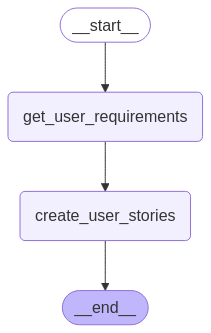

In [ ]:
from IPython.display import Image
from langgraph.graph import StateGraph, START, END

# Build workflow
optimizer_builder = StateGraph(LifeCycleState)

# # Add nodes
# optimizer_builder.add_node("get_user_requirements", get_user_requirements)
# optimizer_builder.add_node("create_user_stories", create_user_stories)

# # Add edges to connect nodes
# optimizer_builder.add_edge(START, "get_user_requirements")
# optimizer_builder.add_edge("get_user_requirements", "create_user_stories")
# optimizer_builder.add_edge("create_user_stories", END)


# Add the nodes
optimizer_builder.add_node("user_requirements", get_user_requirements)
optimizer_builder.add_node("generate_user_stories", generate_user_stories)
optimizer_builder.add_node("product_owner_review", review_by_product_owner)
optimizer_builder.add_node("create_design_documents", create_design_documents)
optimizer_builder.add_node("revise_user_stories", revise_user_stories)
optimizer_builder.add_node("review_design_documents", review_design_documents)
optimizer_builder.add_node("generate_code", generate_code)


# Add edges to connect nodes
optimizer_builder.add_edge(START, "user_requirements")
optimizer_builder.add_edge("user_requirements", "generate_user_stories")
optimizer_builder.add_edge("generate_user_stories", "product_owner_review")
optimizer_builder.add_conditional_edges(
    "product_owner_review",
    route_review_design_document,
    {
        "Accepted": "create_design_documents",
        "Feedback": "revise_user_stories",
    },
)
optimizer_builder.add_edge("revise_user_stories", "generate_user_stories")
optimizer_builder.add_edge("create_design_documents", "review_design_documents")
optimizer_builder.add_conditional_edges(
    "review_design_documents",
    route_product_owner_review,
    {
        "Accepted": "generate_code",
        "Feedback": "create_design_documents",
    },
)
optimizer_builder.add_edge("generate_code", END)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Save workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [7]:
prompt = "I want to develop a user management system with two user types: Admin and User. Admins will have the ability to create, list, update, and delete users, while Users will only be able to retrieve their own details using their user ID."
state = optimizer_workflow.invoke({"prompt": prompt})

user_story:  {'project': {'key': 'LI'}, 'summary': 'As an Admin, I want to create a new user so that I can manage user accounts', 'description': 'Admins should be able to create new users with required details\n            Acceptance Criteria:\n            \n- The system allows Admins to create new users\n- The system validates required user details\n- The system saves the new user details successfully', 'issuetype': {'name': 'Story'}, 'priority': {'name': 'Medium'}}
user_story:  {'project': {'key': 'LI'}, 'summary': 'As an Admin, I want to list all users so that I can view user accounts', 'description': 'Admins should be able to view a list of all users\n            Acceptance Criteria:\n            \n- The system displays a list of all users\n- The list includes required user details\n- The system allows Admins to filter or search users', 'issuetype': {'name': 'Story'}, 'priority': {'name': 'Medium'}}
user_story:  {'project': {'key': 'LI'}, 'summary': "As an Admin, I want to update a